In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray, rgb2hed
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import dilation, erosion, disk, opening, closing, area_closing, area_opening
from skimage.exposure import equalize_hist
from skimage.measure import label
from scipy import ndimage as ndi
from sklearn.cluster import KMeans

## Importing the data

In [164]:
train_df = pd.read_csv("train_metadata.csv")
test_df = pd.read_csv("test_metadata.csv")

train_files = train_df["ID"].to_list()
labels_train = train_df["label"].to_list()
test_files = test_df["ID"].to_list()


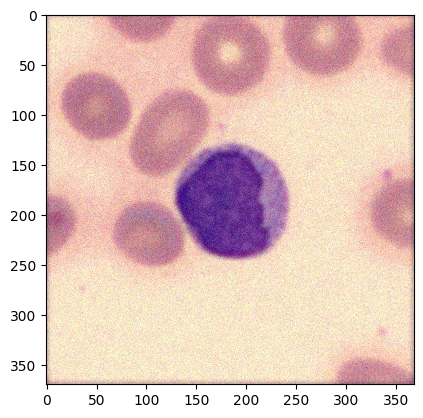

In [165]:
# Verifying if everything works
train_idx = np.random.randint(0, len(train_files))
X = io.imread(f"./train/{train_files[train_idx]}")
plt.imshow(X)

## Data Enhancement

## Segmentation #1 : Watershed (bad) 

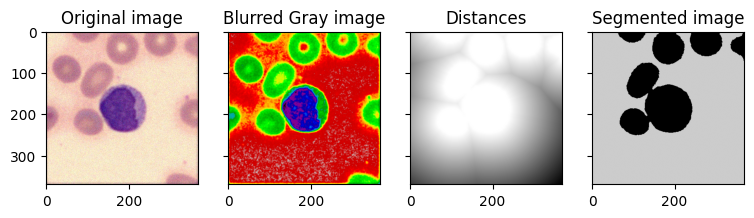

In [166]:
X_smooth = ndi.gaussian_filter(rgb2gray(X), 1.0)
def select_cell(X):
    thresh = threshold_otsu(X)
    X_mask = X > thresh
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels,distance = select_cell(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()

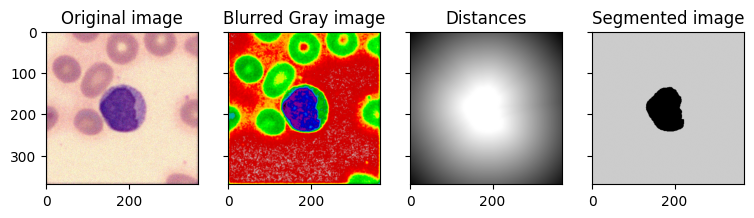

In [167]:
def select_nucleus(X):
    thresh = threshold_otsu(X)
    X_mask = X > 0.4
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels_nucleus, distance_nucleus = select_nucleus(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance_nucleus, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels_nucleus, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()

## Segmentation #2 : Multi-thresh Otsu Method

[0.43228361 0.73402149]


(np.float64(-0.5), np.float64(367.5), np.float64(369.5), np.float64(-0.5))

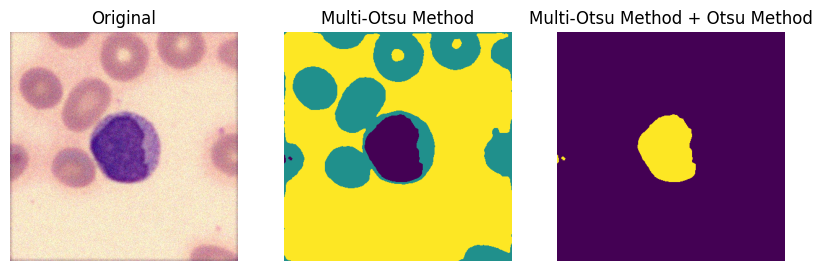

In [168]:
X_smooth = ndi.gaussian_filter(rgb2gray(X), 1.8)
threshs = threshold_multiotsu(X_smooth, classes=3)
regions = np.digitize(X_smooth, bins=threshs)
print(threshs)

thresh2 = threshold_otsu(regions)
nucleus = (regions < thresh2).astype(float)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu Method')
ax[1].axis('off')

ax[2].imshow(nucleus)
ax[2].set_title('Multi-Otsu Method + Otsu Method')
ax[2].axis('off')

We managed to correclty segment the nucleus. It's time to segment the rest of the cell.

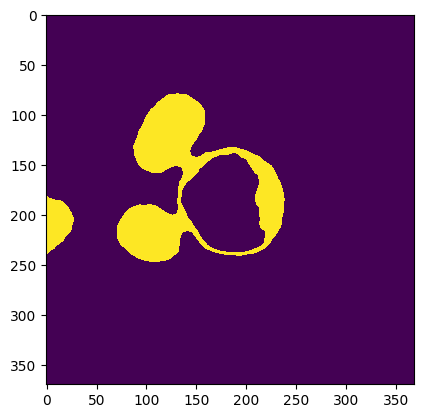

In [180]:
cell_mask = (dilation(regions, disk(5))==1)
labels_cell = label(cell_mask)

nucleus_bool = nucleus.astype(bool)
nucleus_bool = nucleus_bool

touching = np.unique(labels_cell[nucleus_bool])
touching = touching[touching!=0]
white_blood_cell = np.isin(labels_cell, touching)

plt.imshow(white_blood_cell)


(np.float64(-0.5), np.float64(367.5), np.float64(369.5), np.float64(-0.5))

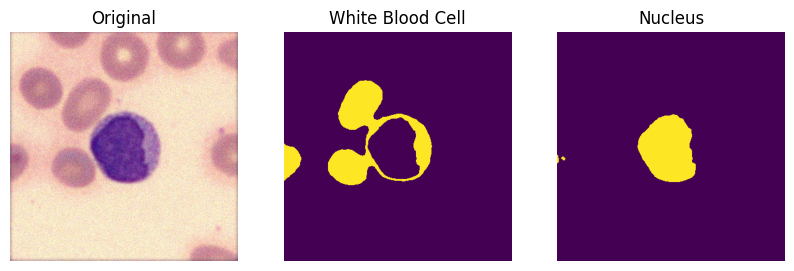

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(white_blood_cell)
ax[1].set_title('White Blood Cell')
ax[1].axis('off')

ax[2].imshow(nucleus)
ax[2].set_title('Nucleus')
ax[2].axis('off')